<a href="https://colab.research.google.com/github/sarrahroseml/finetuning-protein-models/blob/main/Nucleotide_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals
- Classify genomic sequences as promoters or enhancer types (enhancer types have 3 classes)

In [1]:
!pip install -q biopython transformers datasets huggingface_hub accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda")

# Promoter Prediction

### Loading Pre-trained Model

In [4]:
num_labels_promoter = 2
model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref",num_labels = num_labels_promoter)
model = model.to(device)

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Dataset loading & Preparation

In [5]:
from datasets import load_dataset, Dataset

#Load promoter dataset from Instadeep Hugging Face resources
dataset_name = "promoter_all"


#load_dataset() to load dataset from HF

train_dataset_promoter = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks",
                                      dataset_name,
                                      split="train",
                                      streaming= False,
)


test_dataset_promoter = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks",
                                      dataset_name,
                                      split="test",
                                      streaming= False,
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
#Get training & validation data
train_sequences_promoter = train_dataset_promoter['sequence']
train_labels_promoter = train_dataset_promoter['label']
train_sequences_promoter, validation_sequences_promoter , train_labels_promoter, validation_labels_promoter= train_test_split(train_sequences_promoter, train_labels_promoter, test_size =0.05, random_state = 42)

#Get test data
test_sequences_promoter = test_dataset_promoter['sequence']
test_labels_promoter = test_dataset_promoter['label']


In [7]:
#Inspect the data
index = -1
sequence, label = train_sequences_promoter[index],train_labels_promoter[index]
print(f"The DNA seq is {sequence}")
print(f"Its associated label is label {label}")
index_TATA = sequence.find("TATA")

print(f"This promoter is a TATA promoter, as the TATA motif is present at the {index}th nucleotide")

The DNA seq is CACACCAGACAAAATTTGGTTAATTTGCGCCCAATATTCATTACTTTGACCTAACCTTTGTTCTGAAGGCCGTGTACAAGGACAAGGCCCTGAGATTATTGCAACAGTAACTTGAAAAACTTTCAGAAGTCTATTCTGTAGGATTAAAGGAATGCTGAGACTATTCAAGTTTGAAGTCCTGGGGGTGGGGAAAAATAAAAAACCTGTGCTAGAAAGCTTAGTATAGCATGTAACTTTAGAGTCCTGTGGAGTCCTGAGTCTCCCACAGACCAGAACAGTCATTTAAAAGTTTTCAGGAAA
Its associated label is label 1
This promoter is a TATA promoter, as the TATA motif is present at the -1th nucleotide


###Tokenising the datasets

In [8]:
#Load the tokenizer
tokeniser = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

In [9]:
#Promoter dataset
ds_train_promoter = Dataset.from_dict({"data": train_sequences_promoter, "labels":train_labels_promoter})
ds_validation_promoter = Dataset.from_dict({"data": validation_sequences_promoter, "labels":validation_labels_promoter})
ds_test_promoter = Dataset.from_dict({"data": test_sequences_promoter, "labels":test_labels_promoter})


def tokenise_function(examples):
  outputs = tokeniser(examples["data"])
  return outputs

#Creating tokenised promoter dataset
#It allows you to apply a processing function to each example in a dataset, independently or in batches.
tokenised_datasets_train_promoter= ds_train_promoter.map(tokenise_function, batched=True, remove_columns=['data'])
tokenised_datasets_validate_promoter = ds_validation_promoter.map(tokenise_function, batched=True, remove_columns=['data'])
tokenised_datasets_test_promoter = ds_test_promoter.map(tokenise_function, batched=True, remove_columns=['data'])


Map:   0%|          | 0/50612 [00:00<?, ? examples/s]

Map:   0%|          | 0/2664 [00:00<?, ? examples/s]

Map:   0%|          | 0/5920 [00:00<?, ? examples/s]

### Finetuning & Evaluation

In [10]:
batch_size = 8
model_name = 'nucleotide-transformer'
#Before instantiating your Trainer, create a TrainingArguments to access all the points of customization during training.
args_promoter = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns = False,
    evaluation_strategy = 'steps',
    save_strategy = "steps",
    learning_rate = 1e-5,
    per_device_train_batch_size = batch_size,
    gradient_accumulation_steps = 1,
    per_device_eval_batch_size = 64,
    num_train_epochs =2,
    logging_steps = 100,
    load_best_model_at_end = True,
    metric_for_best_model = "f1_score",
    label_names = ['labels'],
    dataloader_drop_last = True,
    max_steps = 1000
)

#Define metric for evaluation
def compute_metrics_f1_score(eval_pred):
  predictions = np.argmax(eval_pred.predictions, axis=-1)
  references = eval_pred.label_ids
  r = {'f1_score': f1_score(references,predictions)}
  return r

In [11]:
trainer = Trainer(
    model.to(device),
    args_promoter,
    train_dataset = tokenised_datasets_train_promoter,
    eval_dataset = tokenised_datasets_validate_promoter,
    tokenizer = tokeniser,
    compute_metrics = compute_metrics_f1_score
)

In [12]:
#Finetune the model by just calling the train method
train_results = trainer.train()

Step,Training Loss,Validation Loss,F1 Score
100,0.465200,0.336985,0.882310
200,0.307400,0.405012,0.845478
300,0.351200,0.462239,0.838795
400,0.285300,0.411557,0.867387
500,0.261200,0.251861,0.927914
600,0.267500,0.230367,0.934658
700,0.226800,0.235465,0.934807
800,0.222300,0.315408,0.906146
900,0.229800,0.194421,0.943338
1000,0.202900,0.191321,0.943527


In [14]:
#Collecting f1 score for each iteration/"step"
curve_eval_f1_score = [[a['step'],a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a.keys()]
eval_f1_score = [c[1] for c in curve_eval_f1_score]
steps = [c[0] for c in curve_eval_f1_score]


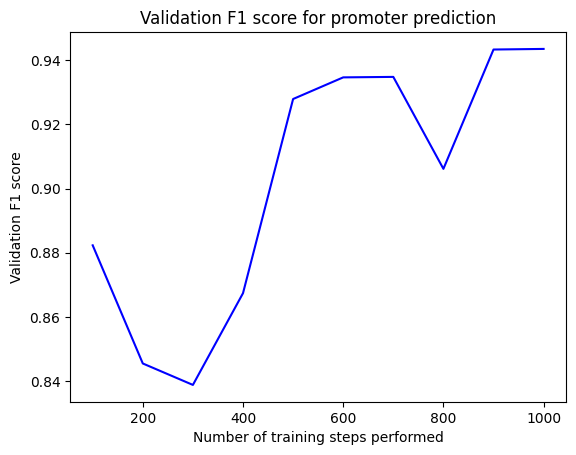

In [15]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 Score')
plt.title('Validation F1 score for promoter prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend
plt.show()

In [16]:
print(f"F1 score on the test dataset: (trainer.predict(tokenised_datasets_test_promoter).metrics['test_f1_score'])")

F1 score on the test dataset: (trainer.predict(tokenised_datasets_test_promoter).metrics['test_f1_score'])


# Enhancer Prediction

In [17]:
num_labels_enhancers_types = 3
model= AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref", num_labels=num_labels_enhancers_types)
model = model.to(device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from datasets import load_dataset, Dataset
dataset_name = "enhancers_types"
train_dataset_enhancers = load_dataset(
    "InstaDeepAI/nucleotide_transformer_downstream_tasks",
    dataset_name,
    split="train",
    streaming=False
)
test_dataset_enhancers = load_dataset(
    "InstaDeepAI/nucleotide_transformer_downstream_tasks",
    dataset_name,
    split="test",
    streaming=False
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [26]:
#Get training data
train_sequences_enhancers = train_dataset_enhancers['sequence']
train_labels_enhancers = train_dataset_enhancers['label']
train_sequences_enhancers, validation_sequences_enhancers, train_labels_enhancers, validation_labels_enhancers = train_test_split(train_sequences_enhancers, train_labels_enhancers, test_size = 0.1, random_state = 42)

#Get test data
test_sequences_enhancers = test_dataset_enhancers['sequence']
test_labels_enhancers = test_dataset_enhancers['label']

In [30]:
#Tokenising the dataset
ds_train_enhancers = Dataset.from_dict({"data":train_sequences_enhancers,'labels':train_labels_enhancers})
ds_validate_enhancers = Dataset.from_dict({"data":validation_sequences_enhancers,'labels':validation_labels_enhancers})
ds_test_enhancers = Dataset.from_dict({"data":test_sequences_enhancers,'labels':test_labels_enhancers})

#Creating the dataset

tokenised_datasets_train_enhancers = ds_train_enhancers.map(tokenise_function, batched=True, remove_columns = ['data'],)
tokenised_datasets_validate_enhancers = ds_validate_enhancers.map(tokenise_function, batched=True, remove_columns = ['data'],)
tokenised_datasets_test_enhancers = ds_test_enhancers.map(tokenise_function, batched=True, remove_columns=['data'],)


Map:   0%|          | 0/13471 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [32]:
#Finetuning and evaluation
batch_size = 8
model_name = 'nucleotide-transformer'
args_enhancers = TrainingArguments(
    f"{model_name}-finetuned-NucleotideTransformer",
    remove_unused_columns = False,
    evaluation_strategy = 'steps',
    save_strategy = 'steps',
    learning_rate = 1e-5,
    per_device_train_batch_size = batch_size ,
    gradient_accumulation_steps = 1, #Gradient accumulation is a technique that simulates a larger batch size by accumulating gradients from multiple small batches before performing a weight update.
    per_device_eval_batch_size = 64,
    num_train_epochs = 2
)

def compute_metrics_mcc(eval_pred):
  predictions = np.argmax(eval_pred.predictions, axis=-1)
  references = eval_pred.label_ids
  r = {'mcc_score': matthews_corrcoef(references, predictions)}
  return r



In [36]:
trainer = Trainer(
    model,
    args_enhancers,
    train_dataset = tokenised_datasets_train_enhancers,
    eval_dataset = tokenised_datasets_validate_enhancers,
    tokenizer = tokeniser,
    compute_metrics= compute_metrics_mcc
)

In [37]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Mcc Score
500,0.624300,0.417690,0.744437
1000,0.437000,0.325373,0.791969
1500,0.381400,0.283190,0.825421
2000,0.294300,0.400371,0.830836
2500,0.244600,0.311243,0.843408
3000,0.224200,0.303958,0.844801


In [39]:
#Validation MCC Score
curve_evaluation_mcc_score = [[a['step'],a['eval_mcc_score']] for a in trainer.state.log_history if 'eval_mcc_score' in a.keys()]
eval_mcc_score = [c[1] for c in curve_evaluation_mcc_score]
steps = [c[0] for c in curve_evaluation_mcc_score]

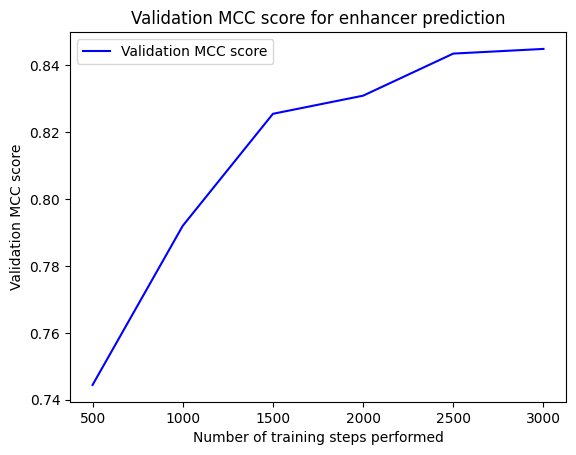

MCC score on the test dataset: 0.45056633820670966


In [40]:
plt.plot(steps, eval_mcc_score, 'b', label = 'Validation MCC score')
plt.title('Validation MCC score for enhancer prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation MCC score')
plt.legend()
plt.show()

print(f"MCC score on the test dataset: {trainer.predict(tokenised_datasets_test_enhancers).metrics['test_mcc_score']}")